# Multi Layer Perceptron As A Function Approximator

We will utilize a multi layer perceptron (MLP) as a function approximator. 

We are given a set of data in 2D that is not linearly separable. We will transform the data into a 2D feature space using an MLP with one hidden-layer of 3 nodes. 

<img src="images/mlp.png" alt="alt text" width="300"/>

The data is first embedded into the 3D space by applying a linear transformation followed by a non-linear activation function, and then it is mapped back to 2D by applying a linear transformation. We hope that data becomes linearly separable in the 2D feature space.

## Create Data

We have a set of data residing on two concentric circles. Data on each circle belongs to separate classes. We formulate a binary classification problem and train the given MLP to perform the task.

In [1]:
import numpy as np

# for reproducibility
np.random.seed(23)

# create data of circles and plot
N=101 # num data points in each circle
t=np.linspace(0,1,N)
r_list = [0.3,1.0] # radius list for circles


x_list = []
y_list = []
for i,r in enumerate(r_list):
    x = r*np.sin(2*np.pi*t) + np.random.randn(N)*0#0.03
    y = r*np.cos(2*np.pi*t) + np.random.randn(N)*0#0.03
    
    x_list.append(x)
    y_list.append(y)

# consolidate data
x_arr = np.concatenate(x_list)
y_arr = np.concatenate(y_list)
data_arr = np.stack([x_arr,y_arr],axis=0)
label_arr = np.concatenate([np.zeros(N,dtype=np.uint8),np.ones(N,dtype=np.uint8)])

# initiate all with the color of 1st quadrant
marker_color_arr = np.ones(2*N,dtype=np.uint8)

# 2nd quadrant
indices = (data_arr[0] < 0) & (data_arr[1] >= 0)
marker_color_arr[indices] = 2

# 3rd quadrant
indices = (data_arr[0] < 0) & (data_arr[1] < 0)
marker_color_arr[indices] = 3

# 4th quadrant
indices = (data_arr[0] >= 0) & (data_arr[1] < 0)
marker_color_arr[indices] = 4

### Helper function to plot data

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

cmap_list = ['Reds','Blues','autumn','winter']

def plot_data(ax,data_arr,label_arr,marker_color_arr):
    unique_label_arr = np.unique(label_arr)
    num_labels = len(unique_label_arr)
    
    ax.set_aspect('equal')
    
    for i in range(num_labels):
        temp_cmap = matplotlib.cm.get_cmap(cmap_list[i])
        
        temp_indices = label_arr==unique_label_arr[i]
        temp_data_arr = data_arr[:,temp_indices]
        temp_label_arr = label_arr[temp_indices]
        temp_marker_color_arr = marker_color_arr[temp_indices]

        ax.scatter(temp_data_arr[0],temp_data_arr[1],s=5,c=temp_marker_color_arr,cmap=temp_cmap,vmin=0)
        
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
        
        

### Plot the data

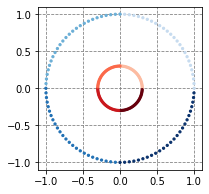

In [3]:
# plot the data
fig,ax = plt.subplots(figsize=(3,3))
plot_data(ax,data_arr,label_arr,marker_color_arr)


## Construct and Train an MLP in PyTorch

### Constructing the model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

# for reproducibility
torch.manual_seed(23)

# for filenames
nonlinearity = 'relu'

class SimpleNN(nn.Module):
    def __init__(self, num_features=1):
        super().__init__()
        
        self.fc1 = nn.Linear(2, num_features, bias=True)
        self.fc2 = nn.Linear(num_features, 2, bias=True)
        
    def forward(self, x):
        s1 = self.fc1(x)
        
        if nonlinearity == 'relu':
            z1 = F.relu(s1)
        elif nonlinearity == 'sigmoid':    
            z1 = torch.sigmoid(s1)
        elif nonlinearity == 'tanh': 
            z1 = torch.tanh(s1)
        else:
            z1 = s1
                 
        y = self.fc2(z1)

        
        return s1,z1,y

### Create a dataset and dataloader

In [5]:
# convert numpy arrays to tensors
samples = torch.as_tensor(data_arr.transpose(), dtype=torch.float32)
labels = torch.as_tensor(label_arr, dtype=torch.long)

dataset_train = torch.utils.data.TensorDataset(samples,labels)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0)

### Train the model

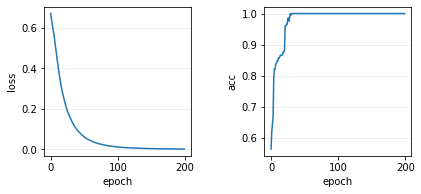

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = SimpleNN(num_features=3)

# move model to the right device
model.to(device)

# define criterion/loss function
criterion = nn.CrossEntropyLoss()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=3e-3, weight_decay=1e-5)

num_epochs = 200
train_loss_list = []
train_acc_list = []
for epoch in range(num_epochs):
    
    # set the model into training mode
    model.train()
    
    num_predictions = 0
    running_loss = 0.0
    running_num_correct_preds = 0
    
    for i, (temp_sample, temp_label) in enumerate(dataloader_train):
        
        # push the mini-batch of data into device
        # if you have a GPU, the data will be pushed into GPU
        temp_sample, temp_label = temp_sample.to(device), temp_label.to(device)
        
        
        # 1. feed-forward pass
        _,_,temp_output = model(temp_sample)
        
        # 2. calculate the loss
        loss = criterion(temp_output, temp_label)
        
        # 3. clear the gradients
        optimizer.zero_grad()
        
        # 4. backward pass (back-propagation)
        # to compute gradients of parameters
        loss.backward()
        
        # 5. update the parameters
        optimizer.step()
        
        
        # get the predicted labels
        _, predicted_label = torch.max(temp_output, 1)
        
        # book-keeping
        num_correct_preds = (predicted_label == temp_label).sum().item()
        
        num_samples = temp_label.size(0)
        num_predictions += num_samples
        
        running_loss += loss.item() * num_samples
        running_num_correct_preds += num_correct_preds
        
    train_loss = running_loss / num_predictions
    train_acc = running_num_correct_preds / num_predictions
#     print(train_loss)
#     print(train_acc)
    
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

# plot the loss and accuracy throughout training
fig,ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(np.arange(num_epochs),train_loss_list)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

ax[1].plot(np.arange(num_epochs),train_acc_list)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.subplots_adjust(left=0.14, bottom=0.29, right=0.99, top=0.98, wspace=0.50 ,hspace=0.20 )

### Save the trained model weights

In [ ]:
# save model weights
filename = 'trained_model_weights__3_nodes_hidden_layer__{}.pth'.format(nonlinearity)
torch.save(model.state_dict(), filename)

## Inference with a trained model

### Load previously saved model weights

In [ ]:
# load saved weights
filename = 'trained_model_weights__3_nodes_hidden_layer__{}.pth'.format(nonlinearity)
state_dict = torch.load(filename)
model.load_state_dict(state_dict)

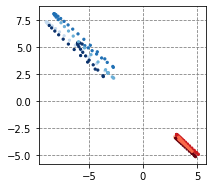

In [7]:
# set the model into evaluation mode
# grads are not computed, so performs faster!
model.eval()
with torch.no_grad():
    s1,z1,y = model(samples.to(device))
    
transformed_data = y.cpu().detach().numpy()
fig,ax = plt.subplots(figsize=(3,3))
plot_data(ax,transformed_data.transpose(),label_arr,marker_color_arr)

### Helper function to plot decision boundary in the data space

In [9]:
# modified from https://github.com/Atcold/pytorch-Deep-Learning/blob/master/res/plot_lib.py
def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    
    # set the model into evaluation mode
    # grads are not computed, so performs faster!
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        _,_,Z = model(data)
    
    Z = Z.detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)

    CS = plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5],colors=['green','red'], alpha=0.3)

### Plot the decision boundary in the data space

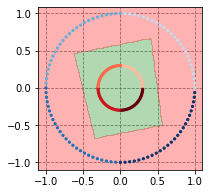

In [10]:
fig,ax = plt.subplots(figsize=(4,3))
plot_model(samples,labels,model)
plot_data(ax,data_arr,label_arr,marker_color_arr)

### How was the data space transformed?

In [11]:
# create grid points
x1 = np.arange(-1.1, 1.11, 0.01)
y1 = np.arange(-1.1, 1.11, 0.1)
xx1, yy1 = np.meshgrid(x1, y1)
xx_yy_1 = np.stack([xx1,yy1],axis=2)

x2 = np.arange(-1.1, 1.11, 0.1)
y2 = np.arange(-1.1, 1.11, 0.01)
xx2, yy2 = np.meshgrid(x2, y2)
xx_yy_2 = np.stack([xx2,yy2],axis=2)

with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx1.reshape(-1), yy1.reshape(-1))).T).float()
    _,_,Z1 = model(data)
    Z1 = Z1.detach()
    Z1 = Z1.reshape(xx1.shape[0],xx1.shape[1],2)
    
    data = torch.from_numpy(np.vstack((xx2.reshape(-1), yy2.reshape(-1))).T).float()
    _,_,Z2 = model(data)
    Z2 = Z2.detach()
    Z2 = Z2.reshape(xx2.shape[0],xx2.shape[1],2)
    
    
    _,_,transformed_data = model(samples.cpu())
    transformed_data = transformed_data.detach().numpy()

### Live animation of transformation

<IPython.core.display.Javascript object>


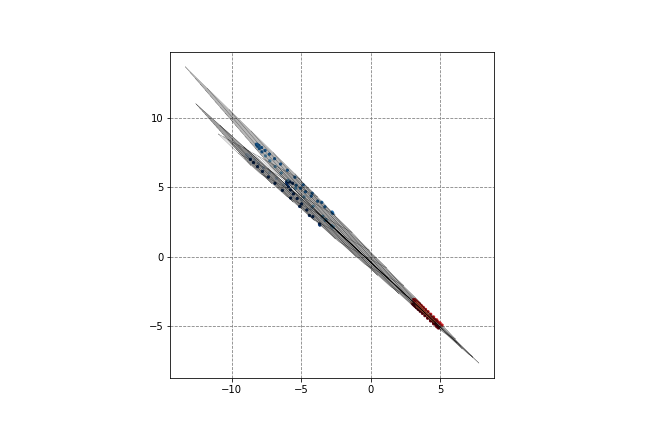

In [12]:
%matplotlib notebook

import time

fig,ax = plt.subplots(figsize=(9,6))

for t in np.arange(0,1.01,0.01):
    temp_Z1 = t*Z1 + (1.-t)*xx_yy_1
    temp_Z2 = t*Z2 + (1.-t)*xx_yy_2
    temp_transformed_data = t*transformed_data + (1.-t)*samples.numpy()

    ax.clear()
    for i in range(xx1.shape[0]):
        ax.plot(temp_Z1[i,:,0],temp_Z1[i,:,1],c='k',lw=.2)
        ax.plot(temp_Z2[:,i,0],temp_Z2[:,i,1],c='k',lw=.2)


    plot_data(ax,temp_transformed_data.transpose(),label_arr,marker_color_arr)
    
    fig.canvas.draw()
    
    time.sleep(0.1)

### Save animation as video

In [ ]:
import imageio
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

fig,ax = plt.subplots(figsize=(9,6),dpi=128)
canvas = FigureCanvas(fig)

filename = 'animation_fps4__3_nodes_hidden_layer__{}.mp4'.format(nonlinearity)
with imageio.get_writer(filename, fps=4) as writer:
    for t in np.arange(0,1.01,0.01):
        temp_Z1 = t*Z1 + (1.-t)*xx_yy_1
        temp_Z2 = t*Z2 + (1.-t)*xx_yy_2
        temp_transformed_data = t*transformed_data + (1.-t)*samples.numpy()

        ax.clear()
        for i in range(xx1.shape[0]):
            ax.plot(temp_Z1[i,:,0],temp_Z1[i,:,1],c='k',lw=.2)
            ax.plot(temp_Z2[:,i,0],temp_Z2[:,i,1],c='k',lw=.2)


        plot_data(ax,temp_transformed_data.transpose(),label_arr,marker_color_arr)

        canvas.draw()       # draw the canvas, cache the renderer
        
        width, height = fig.get_size_inches() * fig.get_dpi()
        image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
        
        writer.append_data(image)
    
    
